In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("..")

In [2]:
df = pd.read_csv("/data/Data/PD/all_df_2.csv")
df = df.rename(columns={"Scanner_type": "Type"})
df = df.rename(columns={"Study": "Site"})
df["Site"].value_counts()

UKBB              245
PD_MCI_CALGARY    121
HAMBURG           113
BIOCOG             94
SALD               78
C-BIG              76
PD_MCI_PLS         62
Japan_dataset      45
Neurocon           42
Taowu              37
Name: Site, dtype: int64

In [3]:
def drop_study(df, sites):
    mask = ~df["Site"].str.contains("|".join(sites), case=True, na=False)
    df = df[mask]
    df.reset_index(drop=True, inplace=True)
    return df


df = drop_study(df, ["PPMI", "HMC", "JGH", "RUH", "SBK", "MUC", "SALD"])

In [4]:
def categorize(df, col):
    type_unique = df[col].unique()
    type_categories = {k: v for k, v in zip(type_unique, np.arange(len(type_unique)))}
    print(type_categories)
    df[col] = df[col].map(type_categories)
    return df, type_categories


def binarize(df, col, val):
    df[col] = (df[col] == val).astype("int")
    return df


df, scanner_dict = categorize(df, "Type")
df, study_dict = categorize(df, "Site")
df = binarize(df, "Group", "PD")

{'GE Discovery 750': 0, 'Siemens Skyra': 1, 'Siemens Prisma_fit': 2, 'Siemens Avanto': 3, 'Siemens Verio': 4, 'Siemens Trio Tim': 5, 'Siemens Trio': 6, 'Siemens Sonata': 7}
{'PD_MCI_CALGARY': 0, 'UKBB': 1, 'HAMBURG': 2, 'C-BIG': 3, 'Neurocon': 4, 'Japan_dataset': 5, 'PD_MCI_PLS': 6, 'Taowu': 7, 'BIOCOG': 8}


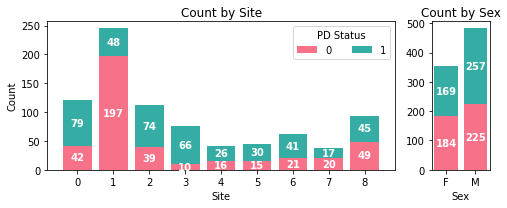

In [5]:
from utils.visualize import view_by_site_sex

view_by_site_sex(df, ["Site", "Sex"]).savefig(
    f"/data/Papers/MIDL2025/data/sex_study_dist.pdf"
)

df = binarize(df, "Sex", "M")

In [6]:
def calculate_percentages(df, col):
    grouped_df = df.groupby(col)[col].value_counts()
    percentages = (grouped_df / grouped_df.sum()).to_list()
    return percentages


print(calculate_percentages(df, "Site"))
print(calculate_percentages(df, "Sex"))

[0.14491017964071856, 0.2934131736526946, 0.13532934131736526, 0.09101796407185629, 0.05029940119760479, 0.05389221556886228, 0.07425149700598803, 0.04431137724550898, 0.1125748502994012]
[0.4227544910179641, 0.577245508982036]


In [7]:
df["strat_column"] = (
    df["Site"].astype("str")
    + "_"
    + df["Sex"].astype("str")
    + "_"
    + df["Group"].astype("str")
)
strata_counts = df["strat_column"].value_counts()
strata_to_drop = strata_counts[strata_counts < 3].index
print(strata_to_drop)
df = df[~df["strat_column"].isin(strata_to_drop)]

Index(['3_1_0'], dtype='object')


In [8]:
from sklearn.model_selection import train_test_split


def stratified_data_split(
    df, target_column, train_size=0.5, val_size=0.1, test_size=0.4, random_state=42
):
    train_val, test = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )
    train, val = train_test_split(
        train_val,
        test_size=val_size / (train_size + val_size),
        stratify=train_val[target_column],
        random_state=random_state,
    )
    return train, val, test


train, val, test = stratified_data_split(df, "strat_column")

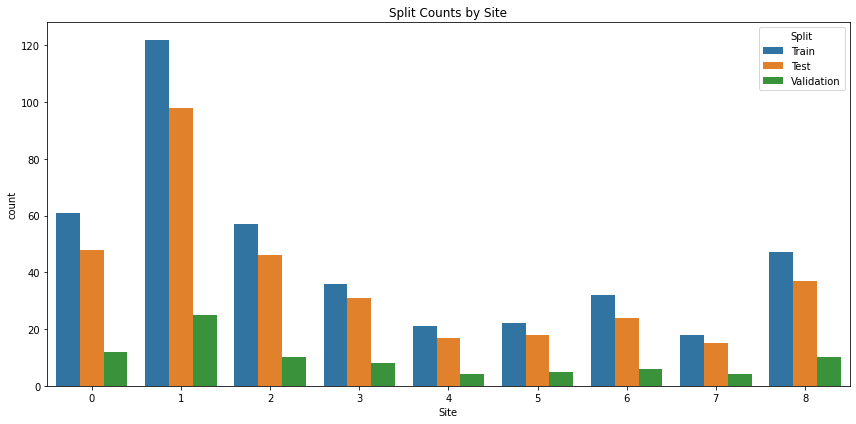

In [10]:
from utils.visualize import split_plot

split_plot(train, test, val, "Site").savefig(
    f"/data/Papers/MIDL2025/data/data_split_site.pdf"
)

In [11]:
train.to_csv("/data/Data/PD/train.csv", index=False)
test.to_csv("/data/Data/PD/test.csv", index=False)
val.to_csv("/data/Data/PD/val.csv", index=False)

In [15]:
def generate_summary_df(df, name):
    """Generates a DataFrame summarizing the counts of 'Sex' and 'Group' within each 'Study' in a DataFrame.

    Args:
      df: The DataFrame to summarize.
      name: The name of the DataFrame (e.g., 'train', 'test', 'validation').

    Returns:
      A DataFrame with columns 'Study', 'Sex', 'Count', and 'Group', 'Count'.
    """

    summary_list = []
    for study, group in df.groupby("Site"):
        for sex, count in group["Sex"].value_counts().items():
            summary_list.append([study, "Sex", sex, count])
        for group_val, count in group["Group"].value_counts().items():
            summary_list.append([study, "Group", group_val, count])

    summary_df = pd.DataFrame(
        summary_list, columns=["Site", "Category", "Value", "Count"]
    )
    return summary_df


# Generate summary DataFrames for each dataset
train_summary_df = generate_summary_df(train, "Train")
test_summary_df = generate_summary_df(test, "Test")
val_summary_df = generate_summary_df(val, "Validation")

In [17]:
# Add a 'Source' column to each DataFrame
train_summary_df["Source"] = "0_Train"
test_summary_df["Source"] = "2_Test"
val_summary_df["Source"] = "1_Val"

# Concatenate the DataFrames
combined_df = pd.concat(
    [train_summary_df, test_summary_df, val_summary_df], ignore_index=True
)

In [19]:
df_pivot = pd.pivot_table(
    combined_df,
    index=["Category", "Value"],
    columns=["Site", "Source"],
    values="Count",
    fill_value=0,
)
df_pivot.to_csv("/data/Papers/MIDL2025/data/data_split.csv")
df_pivot

Site                 0                    1                    2               \
Source         0_Train 1_Val 2_Test 0_Train 1_Val 2_Test 0_Train 1_Val 2_Test   
Category Value                                                                  
Group    0          21     4     17      98    20     79      20     3     16   
         1          40     8     31      24     5     19      37     7     30   
Sex      0          24     5     19      49    10     39      19     3     15   
         1          37     7     29      73    15     59      38     7     31   

Site                 3  ...      5       6                    7               \
Source         0_Train  ... 2_Test 0_Train 1_Val 2_Test 0_Train 1_Val 2_Test   
Category Value          ...                                                    
Group    0           4  ...      6      11     2      8      10     2      8   
         1          32  ...     12      21     4     16       8     2      7   
Sex      0          19  ...     10      14     2     10       8     2      7   
         1          17  ...      8      18     4     14      10     2      8   

Site                 8               
Source         0_Train 1_Val 2_Test  
Category Value                       
Group    0          25     5     19  
         1          22     5     18  
Sex      0          21     4     16  
         1          26     6     21  

[4 rows x 27 columns]

In [ ]:
import os

import nibabel as nib
import torch
from tqdm.auto import tqdm


def prepare(csv_path, img_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path, low_memory=True)

    for i in tqdm(range(len(df))):
        file_name = str(df.iloc[i]["Subject"]) + ".nii.gz"
        img_name = os.path.join(img_dir, os.path.basename(file_name))
        img = nib.load(img_name).get_fdata().astype("f4")

        PD = torch.tensor(df.iloc[i]["Group"])
        sex = torch.tensor(df.iloc[i]["Sex"])
        study = torch.tensor(df.iloc[i]["Site"])
        scanner_type = torch.tensor(df.iloc[i]["Type"])

        img = torch.tensor(np.expand_dims(img, 0))
        torch.save((img, PD, sex, study, scanner_type), os.path.join(save_dir, f"{i}"))


img_dir = "/data/Data/PD/images"

prepare("/data/Data/PD/train.csv", img_dir, "/data/Data/PD/train")
prepare("/data/Data/PD/val.csv", img_dir, "/data/Data/PD/val")
prepare("/data/Data/PD/test.csv", img_dir, "/data/Data/PD/test")

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]